# Session-based Recs with Transformers4Rec: ETL

Followed a step by step tutorial:
https://nvidia-merlin.github.io/Transformers4Rec/main/examples/tutorial/index.html

## Imports

In [28]:
import os
import numpy as np
import pandas as pd
import glob

## Read E-Commerce Data
preprocessing already carried out:\
- `event_time` $\rightarrow$ `event_time_ts` = time when the event happened (UTC)
- `prod_first_event_time_ts` = indicates the timestamp that an item was seen first time
- removed rows where the `user_session` is Null. 2 rows removed.
- label encoded `user_session` $\rightarrow$ integers
- removed consequetively repeated (user,item) interactions

In [29]:
# define where the data is kept
INPUT_DATA_DIR = os.environ.get("INPUT_DATA_DIR", '../data/')
df = pd.read_csv(os.path.join(INPUT_DATA_DIR, '2019-Oct-Processed.csv'), index_col=0)

In [30]:
df.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,event_time_ts,user_session,prod_first_event_time_ts
0,view,1004768,2053013555631882655,electronics.smartphone,samsung,251.47,546521725,1.570361e+09,2,1.569891e+09
1,view,1005098,2053013555631882655,electronics.smartphone,samsung,152.58,546521725,1.570361e+09,2,1.569897e+09
2,view,1005073,2053013555631882655,electronics.smartphone,samsung,1153.03,546521725,1.570361e+09,2,1.569888e+09
3,view,1004871,2053013555631882655,electronics.smartphone,samsung,286.60,546521725,1.570361e+09,2,1.569896e+09
4,view,1004751,2053013555631882655,electronics.smartphone,samsung,197.15,546521725,1.570361e+09,2,1.569897e+09


In [31]:
df.shape

(6390928, 10)

In [32]:
df.isnull().any()

event_type                  False
product_id                  False
category_id                 False
category_code                True
brand                        True
price                       False
user_id                     False
event_time_ts               False
user_session                False
prod_first_event_time_ts    False
dtype: bool

## Categorical Feature Encoding
- label encode all categorical features
- add one to all category encodings as `0` is reserved for padding

In [33]:
cat_feats = ['user_session', 'category_code', 'brand', 'user_id', 'product_id', 'category_id', 'event_type']

In [34]:
for cat in cat_feats:
    df[cat] = df[cat].astype('category')
    df[cat] = df[cat].cat.codes
    df[cat] = df[cat]+1

In [35]:
df.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,event_time_ts,user_session,prod_first_event_time_ts
0,3,790,85,95,2076,251.47,598877,1.570361e+09,1,1.569891e+09
1,3,1046,85,95,2076,152.58,598877,1.570361e+09,1,1.569897e+09
2,3,1022,85,95,2076,1153.03,598877,1.570361e+09,1,1.569888e+09
3,3,875,85,95,2076,286.60,598877,1.570361e+09,1,1.569896e+09
4,3,780,85,95,2076,197.15,598877,1.570361e+09,1,1.569897e+09


## Extract Temporal Features

In [36]:
# convert to int
df['event_time_ts'] = df['event_time_ts'].astype('int')
df['prod_first_event_time_ts'] = df['prod_first_event_time_ts'].astype('int')

In [37]:
# create time features

df['session_time'] = pd.to_datetime(df.event_time_ts,unit='s').rename('event_time_dt')
df['sessiontime_weekday'] = df.session_time.dt.weekday.rename('et_dayofweek')

In [38]:
# create cycling features from the sessiontime_weekday column

def get_cycled_feature_value_sin(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_sin = np.sin(2*np.pi*value_scaled)
    return value_sin

def get_cycled_feature_value_cos(col, max_value):
    value_scaled = (col + 0.000001) / max_value
    value_cos = np.cos(2*np.pi*value_scaled)
    return value_cos

df['weekday_sin'] = get_cycled_feature_value_sin(df.sessiontime_weekday,7).rename('et_dayofweek_sin')
df['weekday_cos'] = get_cycled_feature_value_cos(df.sessiontime_weekday,7).rename('et_datofweek_cos')

<AxesSubplot:>

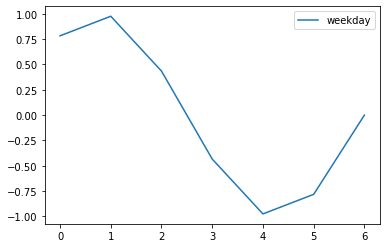

In [39]:
# demonstrate the effect of cycling weekday features
d = {'weekday':[1,2,3,4,5,6,7]}
test_df = pd.DataFrame(data=d)
distribution = get_cycled_feature_value_sin(test_df,7)
distribution.plot.line()

### Add Product Recency Feature

In [40]:
def transform(columns,df):
    for column in columns:
        item_first_timestep = df['prod_first_event_time_ts']
        delta_days = (df[column] - item_first_timestep) / (60*60*24)
        df[column + "_age_days"] = delta_days * (delta_days>=0)
        return df[column + "_age_days"]

In [41]:
recency_features = transform(['event_time_ts'],df)

In [42]:
def normalize(data):
    return (data-data.mean())/data.std()
# add 1e-10 to values to offset from zero to avoid log(0) = -inf
recency_features_norm = normalize(np.log(recency_features+1e-10))

In [43]:
df['product_recency_days_log_norm'] = recency_features_norm

### Normalize Continuous Features

In [44]:
# Smoothing price long-tailed and applying standardization
df['price'] = df['price']+1e-10
df['price_log_norm'] = normalize(np.log(df['price']))

In [45]:
# relative price to the average price for the category_id
def relative_price_to_avg_categ(col,df):
    epsilon = 1e-5
    col = ((df['price'] - df[col]) / (df[col] + epsilon)) * (df[col] > 0).astype(int)
    return col


In [46]:
avg_category_id_pr = df.groupby(['category_id'])['price'].mean().to_frame().reset_index()

In [47]:
df['avg_category_id_pr'] = df['category_id'].map(avg_category_id_pr.set_index('category_id')['price'])

In [48]:
df.head()

,event_type,product_id,category_id,category_code,brand,price,user_id,event_time_ts,user_session,prod_first_event_time_ts,session_time,sessiontime_weekday,weekday_sin,weekday_cos,event_time_ts_age_days,product_recency_days_log_norm,price_log_norm,avg_category_id_pr
0,3,790,85,95,2076,251.47,598877,1570361085,1,1569890856,2019-10-06 11:24:45,6,-0.781831,0.623491,5.442465,0.374468,0.330580,519.009767
1,3,1046,85,95,2076,152.58,598877,1570361154,1,1569896681,2019-10-06 11:25:54,6,-0.781831,0.623491,5.375845,0.370837,0.024237,519.009767
2,3,1022,85,95,2076,1153.03,598877,1570361159,1,1569888057,2019-10-06 11:25:59,6,-0.781831,0.623491,5.475718,0.376264,1.264276,519.009767
3,3,875,85,95,2076,286.60,598877,1570361199,1,1569896322,2019-10-06 11:26:39,6,-0.781831,0.623491,5.380521,0.371093,0.410756,519.009767
4,3,780,85,95,2076,197.15,598877,1570361213,1,1569896971,2019-10-06 11:26:53,6,-0.781831,0.623491,5.373171,0.370690,0.181369,519.009767


In [49]:
df['relative_price_to_avg_categ'] = ((df['price']-df['avg_category_id_pr'])/df['avg_category_id_pr'])*((df['avg_category_id_pr']>0).astype(int))

### Grouping Interactions

#### Aggregate by sesssion id and creates the sequential features

In [170]:
# features to include in the data frame for training
groupby_feats = ['user_session','event_time_ts','category_code','brand','user_id','product_id','category_id','event_type','session_time','sessiontime_weekday','weekday_sin','weekday_cos','product_recency_days_log_norm','price_log_norm','relative_price_to_avg_categ']
gdf = df[groupby_feats]